# 1. 세그멘테이션 준비하기

In [10]:
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

(680, 510, 3)


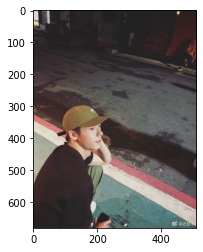

In [11]:
# 이미지 불러오기
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/2.jpeg'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

# 2. 세그멘테이션 

In [12]:
#모델 불러오기
# 저장할 파일 이름을 결정합니다
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# 다운로드를 시작합니다
urllib.request.urlretrieve(model_url, model_file)

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7f3f41474070>)

In [13]:
#모델 생성
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

In [14]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

### 모델이 생성한 결과물 확인
- segvales : class_ids, masks
- output : 세그멘테이션 된 결과가 각각 다른 색상으로 담김

In [15]:
segvalues, output = model.segmentAsPascalvoc(img_path)

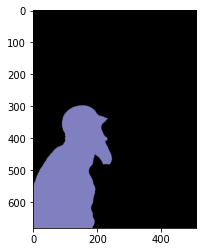

In [16]:
plt.imshow(output)
plt.show()

In [17]:
#class_ids와 masks를 확인
segvalues

{'class_ids': array([ 0, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False]])}

In [18]:
#person labe임을 확인
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
person


output 변수는 BGR 스케일로 이미지를 출력하기 때문에 RGB로 변경해준 뒤 seg_color에 저장

In [19]:
seg_color = (128,128,192)

(680, 510)


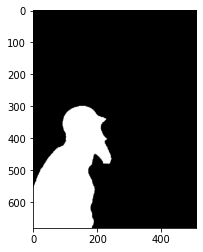

In [20]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

원본 사진과 비교해 얼마나 잘 분리되었는지 확인하기

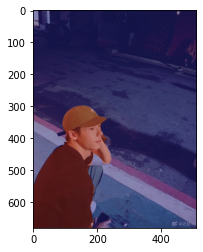

In [21]:
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

# 3. 배경 흐리게 하기

blur() 함수를 이용해 배경 흐리게 만들기

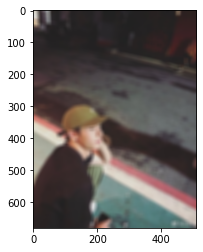

In [25]:
# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_orig_blur = cv2.blur(img_orig, (15,15))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

세그멘테이션 마스크 이용해 배경만 추출하기
- bitwise_not : 배경과 사람 픽셀 숫자 바뀌어 이미지 반전시킴
- bitwise_and : 객체가 0일 때 and 연산을 통해 해당 픽셀 0으로 만들어 사라지게 만들고 배경만 있는 영상 얻을 수 있음

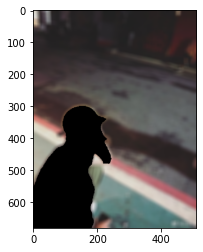

In [26]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

배경과 원본 사진 합치기
- np.where(조건, 참, 거짓) : 원본 이미지값 가져오고 아닌 영역은 블러처리

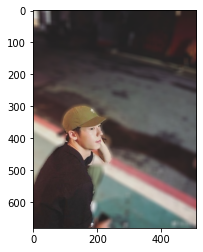

In [27]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

첫 세그멘테이션이 완료되었다.   
얼굴과 몸통 부위는 잘 구분해 그럴듯한 아웃포커싱을 만들어내는 것 같다.   

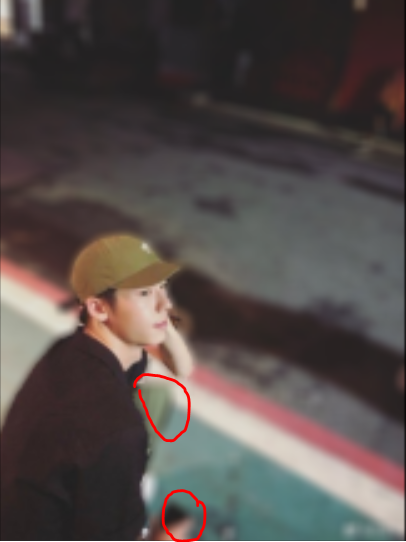   
하지만 빨간색 동그라미친 부분은 무릎과 손인데 사람의 한 부위로 인식하지 못하는 것 같다.   
__전신 사진처럼 한 번에 이어진 느낌이 아니라 그런 것 같기도 하다.__

# 4. 다른 사진에도 적용하기

In [31]:
img_2 = os.getenv('HOME')+'/aiffel/human_segmentation/images/sec.jpg'  
img_orig_2 = cv2.imread(img_2) 

In [32]:
model2 = semantic_segmentation()
model2.load_pascalvoc_model(model_file)

In [33]:
segvalues2, output2 = model2.segmentAsPascalvoc(img_2)

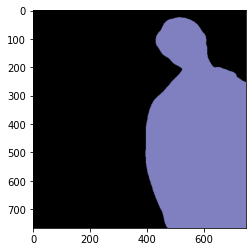

In [35]:
plt.imshow(output2)
plt.show()

(766, 749)


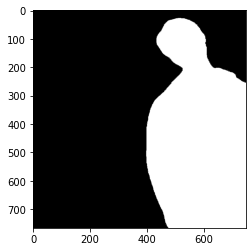

In [51]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
seg_map2 = np.all(output2==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map2, cmap='gray')
plt.show()

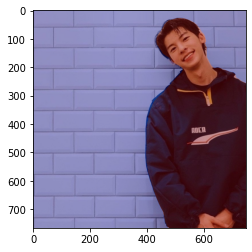

In [53]:
img_show2 = img_orig_2.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask2 = seg_map2.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask2 = cv2.applyColorMap(img_mask2, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show2 = cv2.addWeighted(img_show2, 0.6, color_mask2, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show2, cv2.COLOR_BGR2RGB))
plt.show()

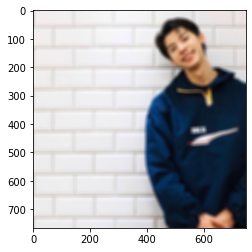

In [54]:
img_orig_blur2 = cv2.blur(img_orig_2, (15,15))  
plt.imshow(cv2.cvtColor(img_orig_blur2, cv2.COLOR_BGR2RGB))
plt.show()

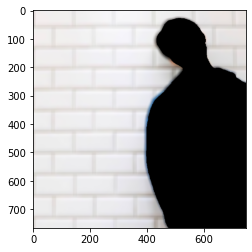

In [55]:
img_mask_color2 = cv2.cvtColor(img_mask2, cv2.COLOR_GRAY2BGR)
img_bg_mask2 = cv2.bitwise_not(img_mask_color2)
img_bg_blur2 = cv2.bitwise_and(img_orig_blur2, img_bg_mask2)
plt.imshow(cv2.cvtColor(img_bg_blur2, cv2.COLOR_BGR2RGB))
plt.show()

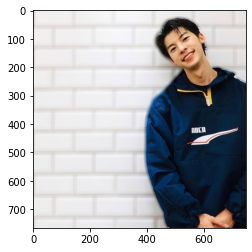

In [57]:
img_concat2 = np.where(img_mask_color2==255, img_orig_2, img_bg_blur2)
plt.imshow(cv2.cvtColor(img_concat2, cv2.COLOR_BGR2RGB))
plt.show()

배경과 객체가 확실하게 구분되는 사진이라 그런지 전반적으로 선이 깔끔하게 따진 것을 볼 수 있다.   
하지만 경계선의 흐릿함이 사람 쪽으로 많이 블러링된 느낌이라 이 부분도 보정할 수 있으면 좋을 것 같다.

In [91]:
img_3 = os.getenv('HOME')+'/aiffel/human_segmentation/images/3.jpg'  
img_orig_3 = cv2.imread(img_3) 

In [92]:
model3 = semantic_segmentation()
model3.load_pascalvoc_model(model_file)

In [93]:
segvalues3, output3 = model3.segmentAsPascalvoc(img_3)

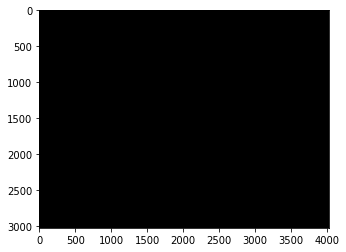

In [94]:
plt.imshow(output3)
plt.show()

..? 사람이 검출되지 않는다   
원본 사진을 불러보자

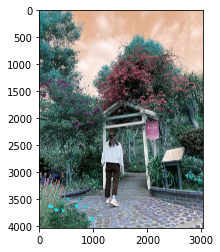

In [95]:
plt.imshow(img_orig_3)

뒷모습에 사람이 있는 영역보다 배경 영역이 훨씬 큰 것 때문에 구분하지 못하는 것 같다.   
우선 사람이 있는 부분을 중심으로 사진을 잘라보았다.   

In [96]:
img_31 = os.getenv('HOME')+'/aiffel/human_segmentation/images/3_.jpg'  
img_orig_31 = cv2.imread(img_31) 

In [97]:
model31 = semantic_segmentation()
model31.load_pascalvoc_model(model_file)

In [98]:
segvalues31, output31 = model31.segmentAsPascalvoc(img_31)

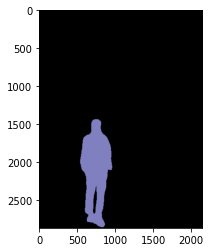

In [99]:
plt.imshow(output31)
plt.show()

가설이 맞았다.
이로써 배경에서 구분하고자 하는 객체의 크기가 배경 비율 대비 많이 작을 경우 구분되지 않는 다는 점을 알 수 있었다.

(2866, 2149)


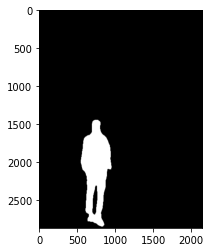

In [100]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
seg_map31 = np.all(output31==seg_color, axis=-1)
print(seg_map31.shape)
plt.imshow(seg_map31, cmap='gray')
plt.show()

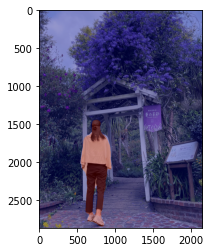

In [101]:
img_show31 = img_orig_31.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask31 = seg_map31.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask31 = cv2.applyColorMap(img_mask31, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show31 = cv2.addWeighted(img_show31, 0.6, color_mask31, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show31, cv2.COLOR_BGR2RGB))
plt.show()

왼쪽 손 부분에서 구분이 명확하게 되지 않은 것 같다.   

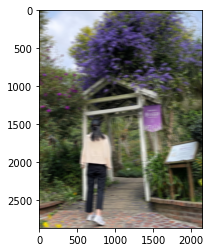

In [102]:
img_orig_blur31 = cv2.blur(img_orig_31, (45, 5))  
plt.imshow(cv2.cvtColor(img_orig_blur31, cv2.COLOR_BGR2RGB))
plt.show()

흔들거리는 느낌을 조금 더 주기 위해 블러링 수치를 다르게 조정하였다.

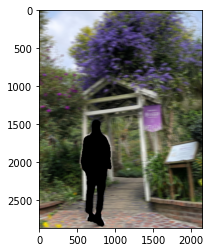

In [103]:
img_mask_color31 = cv2.cvtColor(img_mask31, cv2.COLOR_GRAY2BGR)
img_bg_mask31 = cv2.bitwise_not(img_mask_color31)
img_bg_blur31 = cv2.bitwise_and(img_orig_blur31, img_bg_mask31)
plt.imshow(cv2.cvtColor(img_bg_blur31, cv2.COLOR_BGR2RGB))
plt.show()

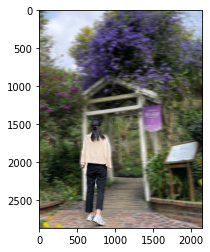

True

In [104]:
img_concat31 = np.where(img_mask_color31==255, img_orig_31, img_bg_blur31)
plt.imshow(cv2.cvtColor(img_concat31, cv2.COLOR_BGR2RGB))
plt.show()
save_path =os.getenv('HOME')+'/aiffel/human_segmentation/images/img_concat31.jpg'
cv2.imwrite(save_path,img_concat31)

생각했던 것 보다 흔들거림 느낌은 없지만 타임슬립하기 직전의 분위기는 형성되었다.   
그렇지만 왼쪽 손 부위의 블러링 처리가 깔끔하게 되지 않은 것을 확인할 수 있었다.   
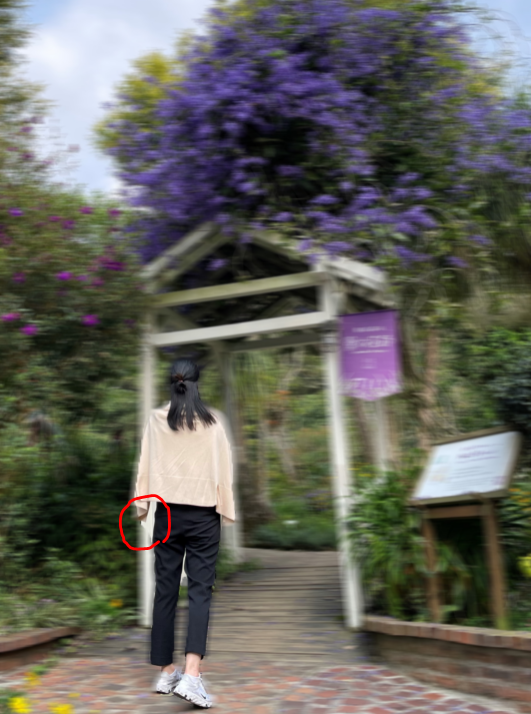

# 5. 다른 객체 세그멘테이션 하기

사람 사진은 벌써 3장이나 다뤄봤다. 그렇다면 다른 객체를 세그멘테이션 해보자   
고양이가 세상을 구한다!    

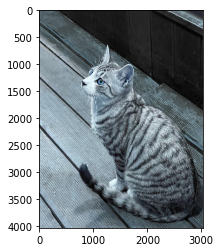

In [121]:
img_4 = os.getenv('HOME')+'/aiffel/human_segmentation/images/4.jpg'  
img_orig_4 = cv2.imread(img_4)
plt.imshow(img_orig_4)

In [107]:
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

In [132]:
segvalues4, output4 = model.segmentAsPascalvoc(img_4)

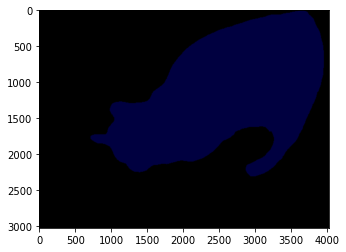

In [133]:
plt.imshow(output4)
plt.show()

(대체 왜 output은 왼쪽으로 90도 회전되어서 출력되는걸까)

In [134]:
for class_id in segvalues4['class_ids']:
    print(LABEL_NAMES[class_id])

background
cat


고양이 클래스로 잘 구분된 것을 확인할 수 있었다.

In [135]:
#고양이 클래스 색상 BGR to RGB
seg_color_cat = (0,0,64)

이전까지 사용한 seg_color의 값은 person 클래스의 값이었다.   
따라서 고양이의 colormap 값인 (63,0,0)을 확인하였고, RGB로 바꾼 값을 seg_color_cat 변수에 저장하였다.

(3024, 4032)


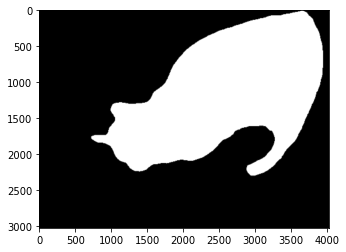

In [136]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
seg_map4 = np.all(output4==seg_color_cat, axis=-1)
print(seg_map4.shape)
plt.imshow(seg_map4, cmap='gray')
plt.show()

왜 그런지 알 수 없지만 model을 지나 output으로 나온 마스크는 왼쪽으로 90도 회전되어 출력되었다.   
그래서 이를 해결하기 위해 mask를 rotate 해주었다.

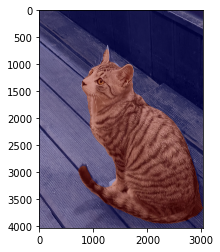

In [148]:
img_show4 = img_orig_4.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask4 = seg_map4.astype(np.uint8) * 255

#에러 발생으로 인한 copy 사용
img_mask4 = cv2.rotate(img_mask4, cv2.ROTATE_90_CLOCKWISE).copy()

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask4 = cv2.applyColorMap(img_mask4, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show4 = cv2.addWeighted(img_show4, 0.6, color_mask4, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show4, cv2.COLOR_BGR2RGB))
plt.show()

아직도 output 회전의 이유는 모르겠지만, 원본과 대조를 위해 mask를 회전시켰다.   
회전에도 문제가 발생하여 copy()를 거쳐 원본과 합쳐지게 하였다.

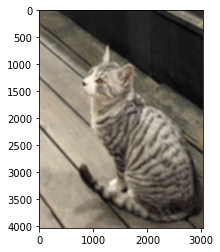

In [149]:
img_orig_blur4 = cv2.blur(img_orig_4, (50, 50))  
plt.imshow(cv2.cvtColor(img_orig_blur4, cv2.COLOR_BGR2RGB))
plt.show()

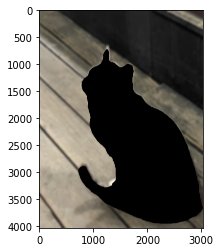

In [150]:
img_mask_color4 = cv2.cvtColor(img_mask4, cv2.COLOR_GRAY2BGR)
img_bg_mask4 = cv2.bitwise_not(img_mask_color4)
img_bg_blur4 = cv2.bitwise_and(img_orig_blur4, img_bg_mask4)
plt.imshow(cv2.cvtColor(img_bg_blur4, cv2.COLOR_BGR2RGB))
plt.show()

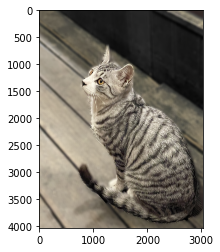

True

In [151]:
img_concat4 = np.where(img_mask_color4==255, img_orig_4, img_bg_blur4)
plt.imshow(cv2.cvtColor(img_concat4, cv2.COLOR_BGR2RGB))
plt.show()
save_path =os.getenv('HOME')+'/aiffel/human_segmentation/images/img_concat4.jpg'
cv2.imwrite(save_path,img_concat4)

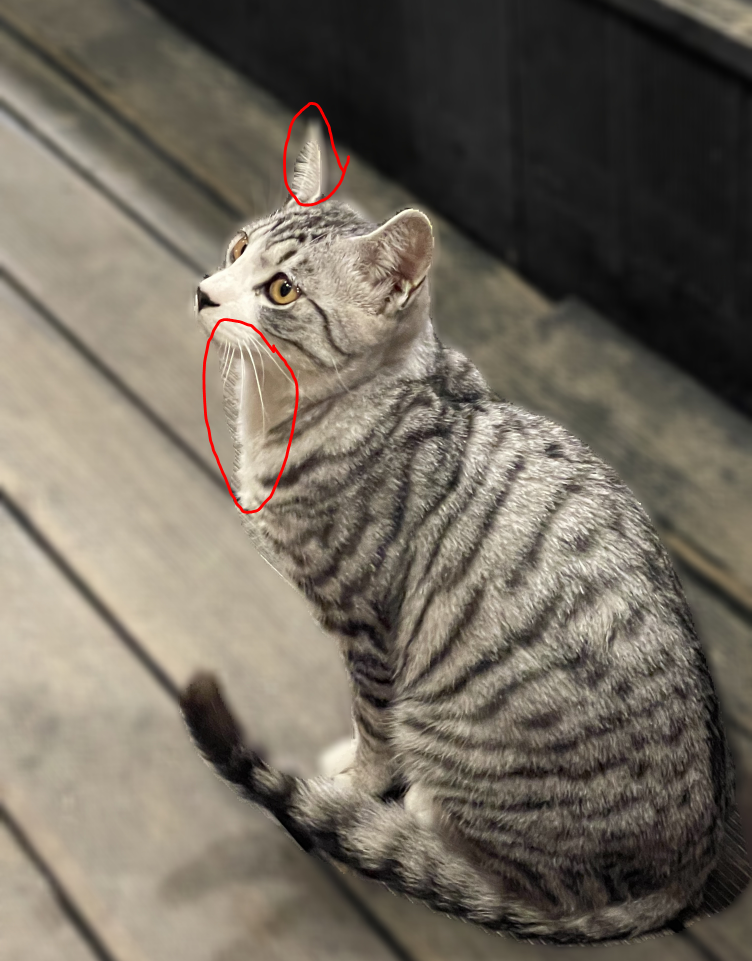
전반적으로 깔끔하게 구분되었다.   
약간의 아쉬운 점은 귀부분과 턱부분이 깔끔하게 구분되지 않은 것이다.